In [1]:
import sparknlp
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import json

from pyspark.ml import Pipeline
# import pyspark.sql.functions as F

import sparknlp
from sparknlp.annotator import *
from sparknlp.base import *
from sparknlp.pretrained import PretrainedPipeline

In [2]:
# Start Spark Session
spark = sparknlp.start()

spark.sparkContext.setLogLevel("OFF")

23/05/05 20:10:56 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
print ("Spark NLP Version :", sparknlp.version())
spark

Spark NLP Version : 4.4.1


In [4]:
# declare schema
schema = StructType([
    StructField("_c0", IntegerType(), True),
    StructField("id", IntegerType(), True),
    StructField("title", StringType(), True),
    StructField("publication", StringType(), True),
    StructField("author", StringType(), True),
    StructField("date", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("url", StringType(), True),
    StructField("content", StringType(), True),
])

In [6]:
#read data
df = spark.read.csv("data/articles1.csv", schema=schema, header=True)
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- publication: string (nullable = true)
 |-- author: string (nullable = true)
 |-- date: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- url: string (nullable = true)
 |-- content: string (nullable = true)



In [7]:
df.show(5)

+---+-----+--------------------+--------------+--------------------+----------+----+-----+----+--------------------+
|_c0|   id|               title|   publication|              author|      date|year|month| url|             content|
+---+-----+--------------------+--------------+--------------------+----------+----+-----+----+--------------------+
|  0|17283|House Republicans...|New York Times|          Carl Hulse|2016-12-31|null| null|null|WASHINGTON  —   C...|
|  1|17284|Rift Between Offi...|New York Times|Benjamin Mueller ...|2017-06-19|null| null|null|After the bullet ...|
|  2|17285|Tyrus Wong, ‘Bamb...|New York Times|        Margalit Fox|2017-01-06|null| null|null|When Walt Disney’...|
|  3|17286|Among Deaths in 2...|New York Times|    William McDonald|2017-04-10|null| null|null|Death may be the ...|
|  4|17287|Kim Jong-un Says ...|New York Times|       Choe Sang-Hun|2017-01-02|null| null|null|SEOUL, South Kore...|
+---+-----+--------------------+--------------+-----------------

In [8]:
# check null values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---+-----+-----------+------+----+-----+-----+-----+-------+
|_c0| id|title|publication|author|date| year|month|  url|content|
+---+---+-----+-----------+------+----+-----+-----+-----+-------+
|  4|  4|    0|          3|  6306|   3|50004|50004|49994|      9|
+---+---+-----+-----------+------+----+-----+-----+-----+-------+



In [9]:
# drop rows with null in following columns (because these are only a fraction of the whole data)
df = df.na.drop(subset=["id","publication","date","content"])

In [10]:
# check if those null values are gone
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---+-----+-----------+------+----+-----+-----+-----+-------+
|_c0| id|title|publication|author|date| year|month|  url|content|
+---+---+-----+-----------+------+----+-----+-----+-----+-------+
|  0|  0|    0|          0|  6303|   0|49992|49992|49991|      0|
+---+---+-----+-----------+------+----+-----+-----+-----+-------+



In [11]:
# total number of articles in the original dataset
df.count()

49992

In [12]:
# convert to Pandas dataframe for visualization
df_pd = df.select("publication", "date", "title", "content").toPandas()
df_pd.head()

,publication,date,title,content
0,New York Times,2016-12-31,House Republicans Fret About Winning Their Hea...,WASHINGTON — Congressional Republicans have...
1,New York Times,2017-06-19,Rift Between Officers and Residents as Killing...,"After the bullet shells get counted, the blood..."
2,New York Times,2017-01-06,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...","When Walt Disney’s “Bambi” opened in 1942, cri..."
3,New York Times,2017-04-10,"Among Deaths in 2016, a Heavy Toll in Pop Musi...","Death may be the great equalizer, but it isn’t..."
4,New York Times,2017-01-02,Kim Jong-un Says North Korea Is Preparing to T...,"SEOUL, South Korea — North Korea’s leader, ..."


In [13]:
# first look at how many articles are there in which publications
df_pub = df_pd.groupby('publication')['title'].count().sort_values(ascending=False)
print(df_pub)

publication
Breitbart           23776
CNN                 11488
New York Times       7803
Business Insider     6753
Atlantic              171
 but ISIS               1
Name: title, dtype: int64


In [14]:
# publication named ' but ISIS' seems wrong, so let's check that row
df_pd[df_pd['publication']==' but ISIS']

,publication,date,title,content
44329,but ISIS,Business Insider,"""Rubio knocks Tillerson’s opposition to regime...",4.0


In [15]:
# since we can't find the content, let's remove it
df_pd = df_pd[df_pd['publication']!=' but ISIS']

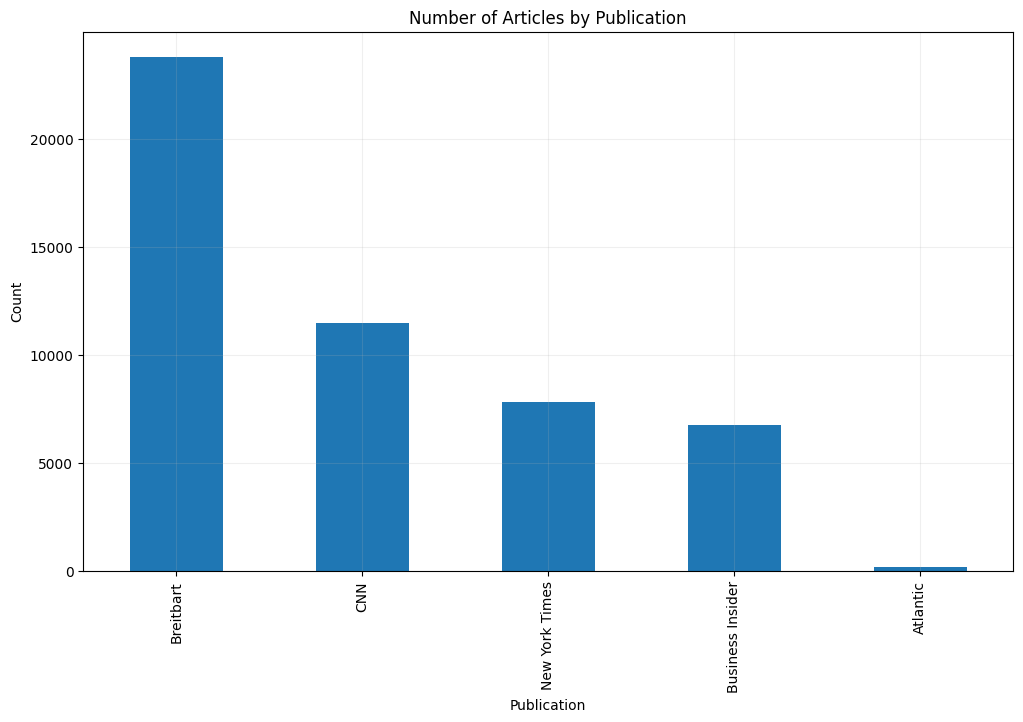

In [16]:
# create visualization for distribution of articles by publication
plt.figure(figsize=[12,7])
df_pd.groupby('publication')['title'].count().sort_values(ascending=False).plot(kind='bar')

plt.xlabel('Publication')
plt.ylabel('Count')
plt.title('Number of Articles by Publication')

plt.grid(alpha=0.2)

In [17]:
# date range for articles in dataset
df_pd['date'].min(), df_pd['date'].max()

('2011-11-22', '2017-06-21')

In [18]:
# create a column showing the length of each article
df_pd['content_length'] = df_pd['content'].str.len()

In [19]:
df_pd.head()

,publication,date,title,content,content_length
0,New York Times,2016-12-31,House Republicans Fret About Winning Their Hea...,WASHINGTON — Congressional Republicans have...,5607
1,New York Times,2017-06-19,Rift Between Officers and Residents as Killing...,"After the bullet shells get counted, the blood...",27834
2,New York Times,2017-01-06,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...","When Walt Disney’s “Bambi” opened in 1942, cri...",14018
3,New York Times,2017-04-10,"Among Deaths in 2016, a Heavy Toll in Pop Musi...","Death may be the great equalizer, but it isn’t...",12274
4,New York Times,2017-01-02,Kim Jong-un Says North Korea Is Preparing to T...,"SEOUL, South Korea — North Korea’s leader, ...",4195


In [20]:
# describe the length of articles
df_pd['content_length'].describe().round()

count     49991.0
mean       3854.0
std        3876.0
min           1.0
25%        1682.0
50%        2853.0
75%        5046.0
max      149346.0
Name: content_length, dtype: float64

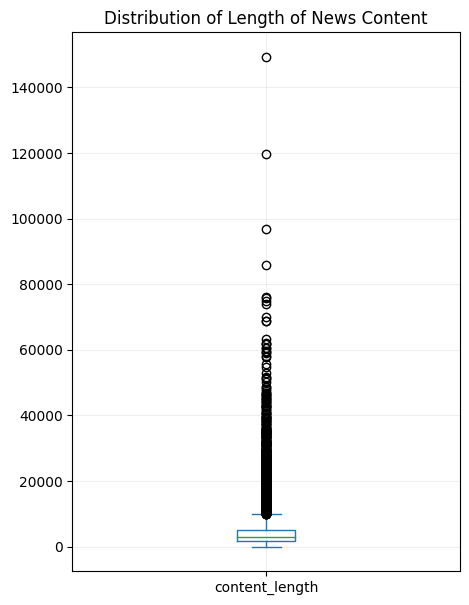

In [25]:
# create visualization for distribution of length of articles
plt.figure(figsize=[5,7])
df_pd['content_length'].plot(kind='box')

plt.title('Distribution of Length of News Content')

plt.grid(alpha=0.2)

In [22]:
# find the max value of the boxplot 
iqr = 5046 - 1682
boxplot_max = 5046 + 1.5*iqr
print(boxplot_max)

10092.0


In [23]:
# there are 1,854 articles that are represented by dots in boxplot
df_pd[df_pd['content_length']>boxplot_max]['title'].count()

1854

In [26]:
# create a random subset of original data to make it < 20MB
df_short = df.orderBy(rand(seed=101)).limit(3000)

In [27]:
# number of articles in the new small dataset
df_short.count()

3000

In [20]:
# create a csv file 
# df_short.write.csv("data/articles_reduced", header=True)

In [3]:
# read from csv
# df_short = spark.read.csv("data/articles_reduced.csv", header=True)
# df_short.printSchema()

In [3]:
# check again for null values
df_short.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_short.columns]).show()

+---+---+-----+-----------+------+----+----+-----+----+-------+
|_c0| id|title|publication|author|date|year|month| url|content|
+---+---+-----+-----------+------+----+----+-----+----+-------+
|  0|  0|    0|          0|   355|   0|3000| 3000|3000|      0|
+---+---+-----+-----------+------+----+----+-----+----+-------+



In [4]:
# select only the columns of our interest
df_final = df_short.select("id", "title", "publication", "date", "content")
df_final.show(5)

+-----+--------------------+----------------+----------+--------------------+
|   id|               title|     publication|      date|             content|
+-----+--------------------+----------------+----------+--------------------+
|69985|These Chris Chris...|Business Insider|2016-06-07|’’ ”Chris Christi...|
|59658|CNN projection: G...|             CNN|2016-12-10|(CNN) CNN project...|
|58071|The debate in 140...|             CNN|2016-09-26|(CNN) CNN Opinion...|
|42739|Pamela Geller: Sl...|       Breitbart|2016-08-02|Slate magazine on...|
|38651|Attack on America...|       Breitbart|2016-08-24|The American Univ...|
+-----+--------------------+----------------+----------+--------------------+
only showing top 5 rows



In [5]:
# first article in dataset (Business InsiderIt )
df_final.collect()[0][4]

'’’ ”Chris Christie’s image among New Jerseyans has become stunningly bad.” ”A Monday poll from Monmouth University found Christie’s approval rating at an   low  —   worse than the negative ratings respondents gave the state Legislature.” ’That survey comes weeks after  that Christie had the ’ ’More than   of New Jerseyans also responded that they believe Christie endorsed presumptive GOP nominee Donald Trump only to improve his chances of obtaining a federal appointment.’ ”Christie’s approval rating in the Monmouth poll stood at a dismal 27% while 63% disapproved of the job the governor is performing. That’s a tick worse than he did in the historically bad Quinnipiac survey, in which his approval rating was 29%. When registered voters were isolated in the Monmouth poll, Christie’s approval dropped from 27% to 26%.” ”The approval rating was a record low for the governor in the Monmouth survey. The state Legislature, of which 30% of New Jerseyans approved, stood better than Christie’s r

In [6]:
# Business Insider article
df_final.collect()[5][4]

'’  ’ ’   The small state of New Hampshire could prove to be of the utmost   importance by the conclusion of Election Day. ’ ’   And, with 25% of precincts reporting, Republican nominee Donald   Trump held a  over Democratic   nominee Hillary Clinton. ’ ”   In the latest  Clinton   held a less than   lead over Trump after holding a much   more substantial lead in the lead up to Tuesday’s vote.  ” ”   The state’s four electoral votes might be the difference in   whether Clinton could hold off a Trump surge, or whether Trump   could complete the improbable and reach 270 electoral votes. ” ’   Polls close in the Granite State at 7 p. m. EST. But late Tuesday   evening, a judge ruled that polls around Dover will stay . ’ ’’ ”   New Hampshire is also home to a competitive Senate race, as well   as one for the governor’s mansion. In the Senate battle,   incumbent Republican Sen. Kelly Ayotte leads Democratic Gov.   Maggie Hassan by 1. 5 points  while Republican Chris   Sununu leads Democrat 

In [7]:
# Business Insider articles are too dirty. For the purpose of this project, exclude them.
df_final = df_final.filter(df_final.publication != "Business Insider")
df_final.show()

+-----+--------------------+--------------+----------+--------------------+
|   id|               title|   publication|      date|             content|
+-----+--------------------+--------------+----------+--------------------+
|59658|CNN projection: G...|           CNN|2016-12-10|(CNN) CNN project...|
|58071|The debate in 140...|           CNN|2016-09-26|(CNN) CNN Opinion...|
|42739|Pamela Geller: Sl...|     Breitbart|2016-08-02|Slate magazine on...|
|38651|Attack on America...|     Breitbart|2016-08-24|The American Univ...|
|24574|Business Since Bi...|New York Times|2016-12-12|When Donald J. Tr...|
|52943|Colombia mudslide...|           CNN|2017-04-01|(CNN) Mudslides k...|
|57117|CNN Student News ...|           CNN|2016-08-23|August 24, 2016, ...|
|55662|Hillary Clinton r...|           CNN|2016-07-01|Washington (CNN) ...|
|20674|Supreme Court Uph...|New York Times|2016-06-30|WASHINGTON  —   T...|
|31116|Trade Deficit Fal...|     Breitbart|2017-04-04|The U. S. trade d...|
|50798|Donal

In [8]:
# most articles have many two or more spaces. convert them to one space
reg_exp = "\\s+"
df_final = df_final.select("id", \
                           "title", \
                           "publication", \
                           "date", \
                           regexp_replace(col("content"), reg_exp, " ").alias("content"))
# df_final.show()

In [15]:
# t5small = T5Transformer() \
#   .pretrained("t5_small", 'en') \
#   .setTask("summarize:")\
#   .setMaxOutputLength(200)\
#   .setInputCols(["documents"]) \
#   .setOutputCol("summaries")

# summarizer_t5small = Pipeline(stages=[
#     document_assembler, t5small
# ])

In [10]:
document_assembler = DocumentAssembler()\
.setInputCol("content")\
.setOutputCol("documents")

# T5-small model for text summarization
t5 = T5Transformer() \
.pretrained("t5_small") \
.setTask("summarize:")\
.setMaxOutputLength(200)\
.setInputCols(["documents"]) \
.setOutputCol("summaries")

t5_small download started this may take some time.
Approximate size to download 241.9 MB
[ | ]t5_small download started this may take some time.
Approximate size to download 241.9 MB
[ / ]Download done! Loading the resource.
[ — ]

2023-05-05 20:11:59.527034: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[OK!]


In [20]:
pipeline = Pipeline().setStages([document_assembler, t5])
results = pipeline.fit(df_final.limit(1)).transform(df_final.limit(1))
results.show(1)

+-----+--------------------+-----------+----------+--------------------+--------------------+--------------------+
|   id|               title|publication|      date|             content|           documents|           summaries|
+-----+--------------------+-----------+----------+--------------------+--------------------+--------------------+
|59658|CNN projection: G...|        CNN|2016-12-10|(CNN) CNN project...|[{document, 0, 18...|[{document, 0, 13...|
+-----+--------------------+-----------+----------+--------------------+--------------------+--------------------+



In [21]:
results.select("summaries.result").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------+
|result                                                                                                                                     |
+-------------------------------------------------------------------------------------------------------------------------------------------+
|[the final race of the 2016 election cycle was held in the deep red state . the republican has a slim majority of 52 seats in the Senate .]|
+-------------------------------------------------------------------------------------------------------------------------------------------+



In [22]:
# empty_df = spark.createDataFrame([['']]).toDF('text')
# pipeline_t5small = summarizer_t5small.fit(empty_df)
# sum_t5small = LightPipeline(pipeline_t5small)

# example_txt = df_final.collect()[5][4]

# res = sum_t5small.fullAnnotate(example_txt)[0]

# print ('Summary:', res['summaries'][0].result)

In [23]:
#T5-base model for text summarization
t5base = T5Transformer() \
  .pretrained("t5_base", 'en') \
  .setTask("summarize:")\
  .setMaxOutputLength(200)\
  .setInputCols(["documents"]) \
  .setOutputCol("summaries")

summarizer_t5base = Pipeline(stages=[
    document_assembler, t5base
])

t5_base download started this may take some time.
Approximate size to download 451.8 MB
[ \ ]t5_base download started this may take some time.
Approximate size to download 451.8 MB
[ | ]Download done! Loading the resource.
[OK!]


In [24]:
pipeline = Pipeline().setStages([document_assembler, t5base])
results = pipeline.fit(df_final.limit(1)).transform(df_final.limit(1))
results.show()

+-----+--------------------+-----------+----------+--------------------+--------------------+--------------------+
|   id|               title|publication|      date|             content|           documents|           summaries|
+-----+--------------------+-----------+----------+--------------------+--------------------+--------------------+
|59658|CNN projection: G...|        CNN|2016-12-10|(CNN) CNN project...|[{document, 0, 18...|[{document, 0, 22...|
+-----+--------------------+-----------+----------+--------------------+--------------------+--------------------+



In [25]:
results.select("summaries.result").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|result                                                                                                                                                                                                                               |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[preliminary votes from the secretary of state show that the Republican has won . the seat had been considered safe Republican in the deep red southern state . the Republicans now hold a slim majority of 52 seats in the Senate .]|
+-----------------------------------------------------------------------

In [ ]:
# pipeline_t5base = summarizer_t5base.fit(empty_df)
# sum_t5base = LightPipeline(pipeline_t5base)

# example_txt = df_final.collect()[5][4]

# res = sum_t5base.fullAnnotate(example_txt)[0]

# print ('Summary:', res['summaries'][0].result)

In [40]:
# "distilbart_cnn_6_6"

In [134]:
# Bart-Xsum model (did not work)
# bart = BartTransformer() \
# .pretrained("distilbart_xsum_12_6") \
# .setTask("summarize:")\
# .setMaxOutputLength(200)\
# .setInputCols(["documents"]) \
# .setOutputCol("summaries")r

In [26]:
# Information extraction using RegexMatcherstinImportIm
# Find 'year' and 'hashtag'

# Step 1: Transform raw texts to `document` annotation
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Step 2: Define the regex rules    
regex_matcher = RegexMatcher()\
    .setRules(["\d{4}, year", "\#[a-zA-Z]+, hashtag"]) \
    .setDelimiter(",") \
    .setInputCols(["document"]) \
    .setOutputCol("matched_text") \
    .setStrategy("MATCH_ALL")

# Define the Pipeline
nlpPipeline = Pipeline(stages=[documentAssembler,regex_matcher])

In [27]:
# Make a sample text
text_list = df_final.rdd.map(lambda x: x[4]).collect()

# Convert the sample_text to a dataframe
spark_df = spark.createDataFrame(text_list, StringType()).toDF("text")

# Fit and transform to get a prediction
result = nlpPipeline.fit(spark_df).transform(spark_df)

In [29]:
result.show(3)

+--------------------+--------------------+--------------------+
|                text|            document|        matched_text|
+--------------------+--------------------+--------------------+
|(CNN) CNN project...|[{document, 0, 18...|[{chunk, 342, 345...|
|(CNN) CNN Opinion...|[{document, 0, 72...|[{chunk, 829, 832...|
|Slate magazine on...|[{document, 0, 73...|[{chunk, 4213, 42...|
+--------------------+--------------------+--------------------+
only showing top 3 rows



In [31]:
# create 'id' column for identifying each article
w = Window().orderBy(lit('A'))
result = result.withColumn("id", row_number().over(w))
result.show(3)

+--------------------+--------------------+--------------------+---+
|                text|            document|        matched_text| id|
+--------------------+--------------------+--------------------+---+
|(CNN) CNN project...|[{document, 0, 18...|[{chunk, 342, 345...|  1|
|(CNN) CNN Opinion...|[{document, 0, 72...|[{chunk, 829, 832...|  2|
|Slate magazine on...|[{document, 0, 73...|[{chunk, 4213, 42...|  3|
+--------------------+--------------------+--------------------+---+
only showing top 3 rows



In [125]:
# result.select("id", "matched_text.metadata").show(1, False)

In [119]:
result.select("id", "matched_text.result").show(4, False)

+---+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |result              

In [35]:
# show matches found by identifier and sequence in each article
result.select("id",explode(arrays_zip(result.matched_text.result, 
                                     result.matched_text.metadata)).alias("cols")) \
       .select("id", expr("cols['0']").alias("Matches Found"),
               expr("cols['1']['identifier']").alias("identifier"),
               expr("cols['1']['chunk']").alias("sequence")).show(15,False)

+---+-------------+----------+--------+
|id |Matches Found|identifier|sequence|
+---+-------------+----------+--------+
|1  |2016         | year     |0       |
|1  |2016         | year     |1       |
|1  |2015         | year     |2       |
|2  |1992         | year     |0       |
|2  |2012         | year     |1       |
|2  |1992         | year     |2       |
|2  |2012         | year     |3       |
|3  |1980         | year     |0       |
|4  |2016         | year     |0       |
|4  |2001         | year     |1       |
|4  |2016         | year     |2       |
|4  |2015         | year     |3       |
|4  |2016         | year     |4       |
|4  |#AUAF        | hashtag  |5       |
|4  |#Kabul       | hashtag  |6       |
+---+-------------+----------+--------+
only showing top 15 rows



In [36]:
# Information Extraction 2nd Example 
# Find consecutive capitalized words, which usually indicates names

# Step 1: Transform raw texts to `document` annotation
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Step 2: Define the regex rules 
regex_matcher = RegexMatcher()\
    .setRules(["[A-Z][a-z]+(?=\s[A-Z])(?:\s[A-Z][a-z]+)+, names"]) \
    .setDelimiter(",") \
    .setInputCols(["document"]) \
    .setOutputCol("matched_text") \
    .setStrategy("MATCH_ALL")

# Define the Pipeline
nlpPipeline = Pipeline(stages=[documentAssembler,regex_matcher])

In [37]:
# Make a sample text
text_list = df_final.rdd.map(lambda x: x[4]).collect()

# Convert the sample_text to a dataframe
spark_df = spark.createDataFrame(text_list, StringType()).toDF("text")

# Fit and transform to get a prediction
result = nlpPipeline.fit(spark_df).transform(spark_df)

In [40]:
# create 'id' column for identifying each article
w = Window().orderBy(lit('A'))
result = result.withColumn("id", row_number().over(w))
result.show(3)

+--------------------+--------------------+--------------------+---+
|                text|            document|        matched_text| id|
+--------------------+--------------------+--------------------+---+
|(CNN) CNN project...|[{document, 0, 18...|[{chunk, 19, 41, ...|  1|
|(CNN) CNN Opinion...|[{document, 0, 72...|[{chunk, 121, 135...|  2|
|Slate magazine on...|[{document, 0, 73...|[{chunk, 36, 46, ...|  3|
+--------------------+--------------------+--------------------+---+
only showing top 3 rows



In [43]:
# show matches found by identifier and sequence in each article
result.select("id",explode(arrays_zip(result.matched_text.result, 
                                     result.matched_text.metadata)).alias("cols")) \
       .select("id", expr("cols['0']").alias("Matches Found"),
               expr("cols['1']['identifier']").alias("identifier"),
               expr("cols['1']['chunk']").alias("sequence")).show(20,False)

+---+-------------------------+----------+--------+
|id |Matches Found            |identifier|sequence|
+---+-------------------------+----------+--------+
|1  |Republican John Kennedy  | names    |0       |
|1  |Democrat Foster Campbell | names    |1       |
|1  |The Republicans          | names    |2       |
|1  |Ku Klux Klan             | names    |3       |
|1  |David Duke               | names    |4       |
|1  |Donald Trump             | names    |5       |
|1  |Baton Rouge              | names    |6       |
|1  |John Kennedy             | names    |7       |
|1  |United States Senate     | names    |8       |
|1  |Vice Mike Pence          | names    |9       |
|1  |John Kennedy             | names    |10      |
|1  |New Orleans              | names    |11      |
|1  |Incumbent Republican Sen | names    |12      |
|1  |David Vitter             | names    |13      |
|1  |Democrat John Bel Edwards| names    |14      |
|2  |Hillary Clinton          | names    |0       |
|2  |Donald 